In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://www.kaggle.com/datasets/timoboz/tesla-stock-data-from-2010-to-2020

# importing the dataset
df = pd.read_csv('tesla-stock-price.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
df.shape

(2416, 7)

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


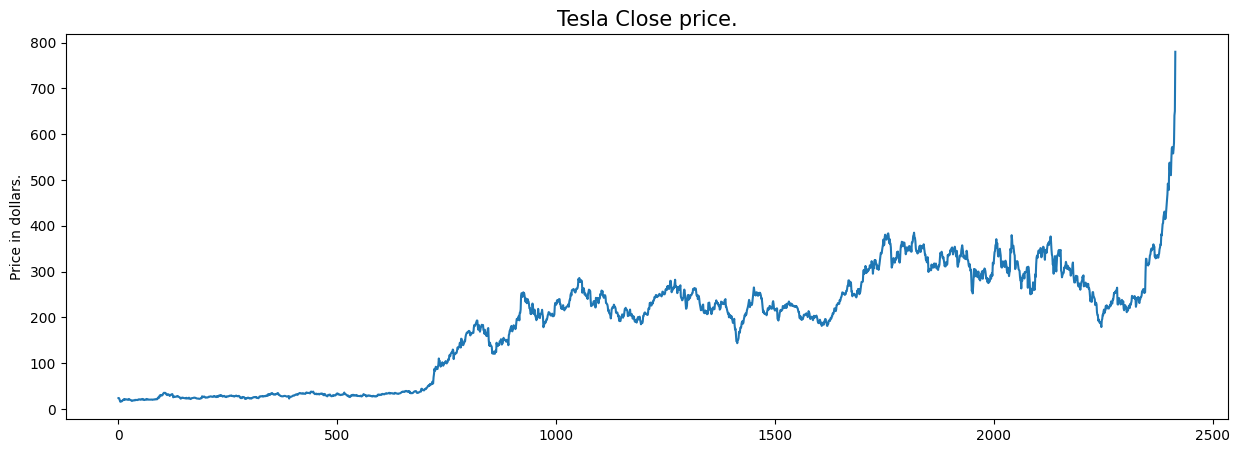

In [6]:
# exploratory data analysis
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [8]:
# data in 'Close' and 'Adj Close' is the same, but is it same for each row?? 
df[df['Close'] == df['Adj Close']].shape

(2416, 7)

In [9]:
# redundent data as 'close' and 'adj close' same, so deleting the 'adj close' col to avoid redundancy
df = df.drop(['Adj Close'], axis=1)

In [10]:
# checking for null values in the dataset
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

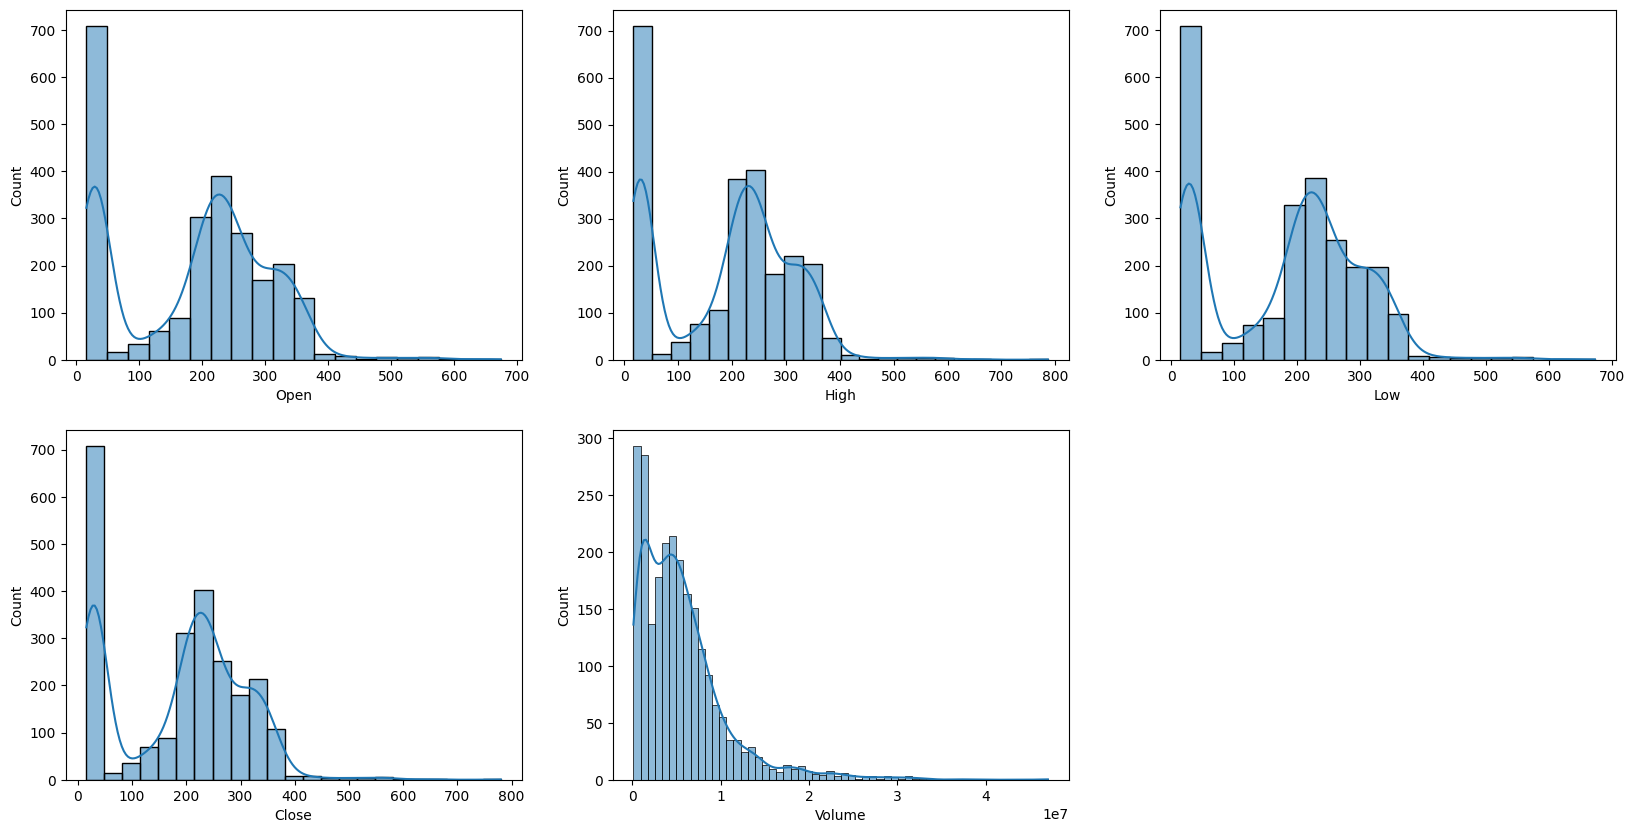

In [11]:
# distribution plot for the continuous features 

features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.histplot(df[col], kde=True)
plt.show()

In [12]:
# there are two peaks in OLHC data, meaning data has varied significantly in two regions
# volume data is skewed

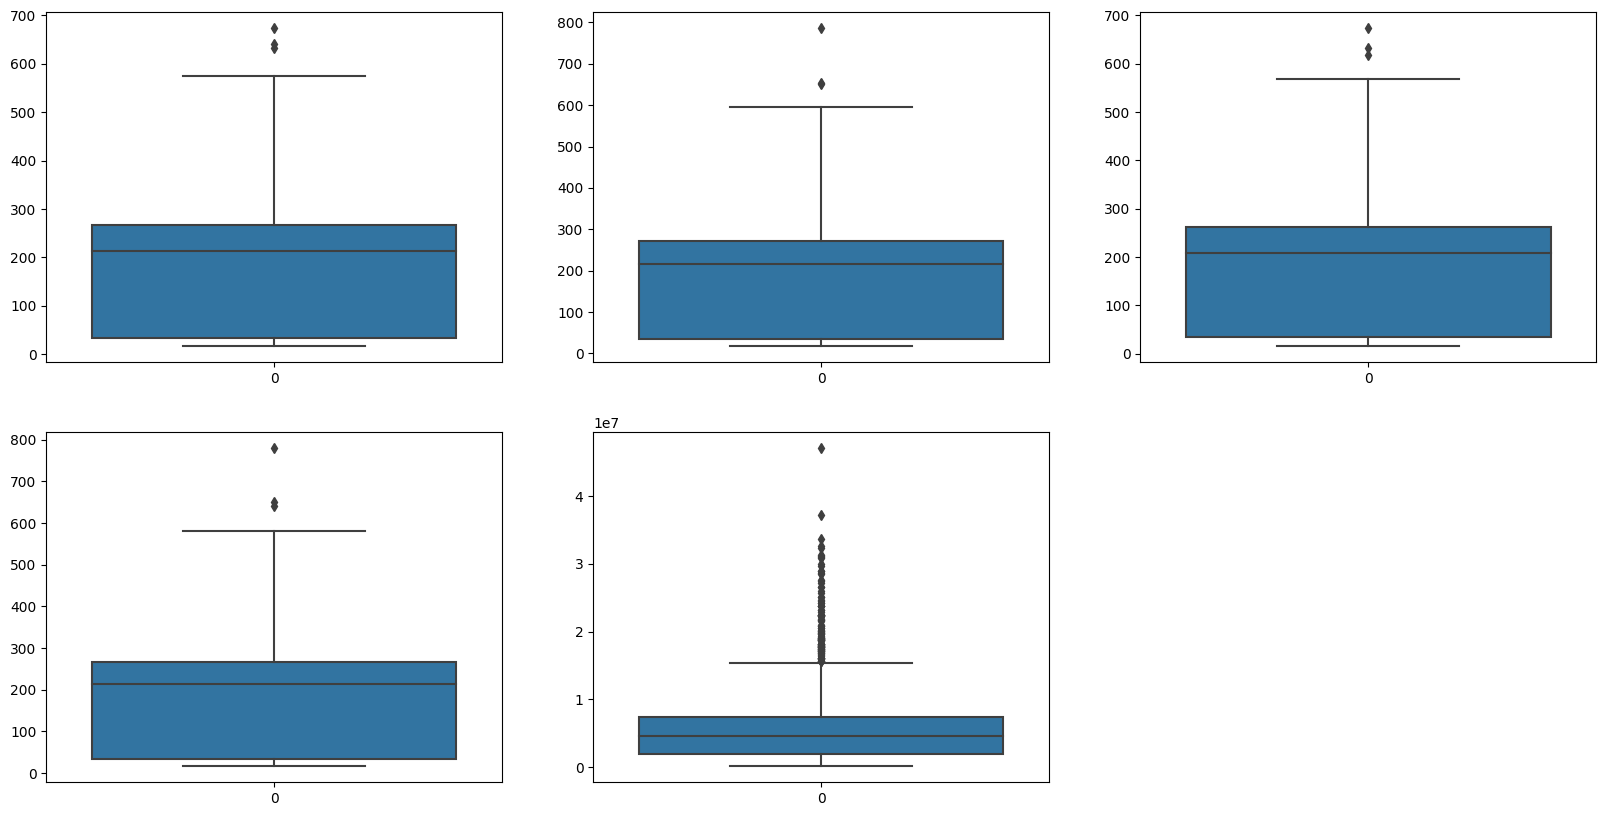

In [13]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [14]:
# only volume data has outliers, the rest of the data is free from outliers

In [15]:
# Feature Engineering
# derive features from existing features

splitted = df['Date'].str.split('-', expand=True)
 
df['day'] = splitted[2].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[0].astype('int')
 
df.head()

,Date,Open,High,Low,Close,Volume,day,month,year
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,29,6,2010
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,30,6,2010
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,1,7,2010
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,2,7,2010
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,6,7,2010


In [16]:
# deriving the quarterly results from this data, because quarterly data influence the stock price
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2416 non-null   object 
 1   Open            2416 non-null   float64
 2   High            2416 non-null   float64
 3   Low             2416 non-null   float64
 4   Close           2416 non-null   float64
 5   Volume          2416 non-null   int64  
 6   day             2416 non-null   int32  
 7   month           2416 non-null   int32  
 8   year            2416 non-null   int32  
 9   is_quarter_end  2416 non-null   int32  
dtypes: float64(4), int32(4), int64(1), object(1)
memory usage: 151.1+ KB


In [17]:
print(df['year'].unique())
print(df.columns)

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month',
       'year', 'is_quarter_end'],
      dtype='object')


In [18]:
# group the data annually and compare how the stock price has evolved
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
data_grouped = df.groupby('year')[numeric_columns].mean().reset_index(drop=True)

In [19]:
df.groupby('is_quarter_end')[numeric_columns].mean()

,Open,High,Low,Close,Volume,day,month,year,is_quarter_end
is_quarter_end,,,,,,,,,
0,185.875081,189.254226,182.449499,186.085081,5.767062e+06,15.710396,6.173886,2014.816213,0.0
1,187.071200,190.232700,183.860262,187.047163,5.180154e+06,15.825000,7.597500,2014.697500,1.0


In [20]:
# prices are higher in months which are quarter-end compared to months which are not
# volume of trades lower in moths that are quarter-end

In [21]:
# adding a few more features
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']

# signal whether to buy or not
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

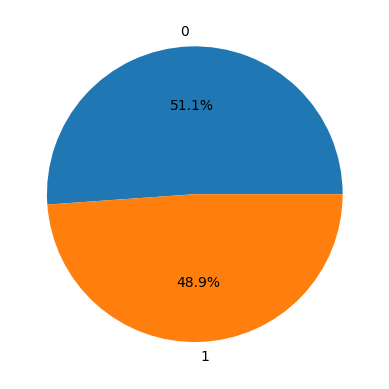

In [22]:
# check whether 'target' feature is balanced or not, using a pie chart
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

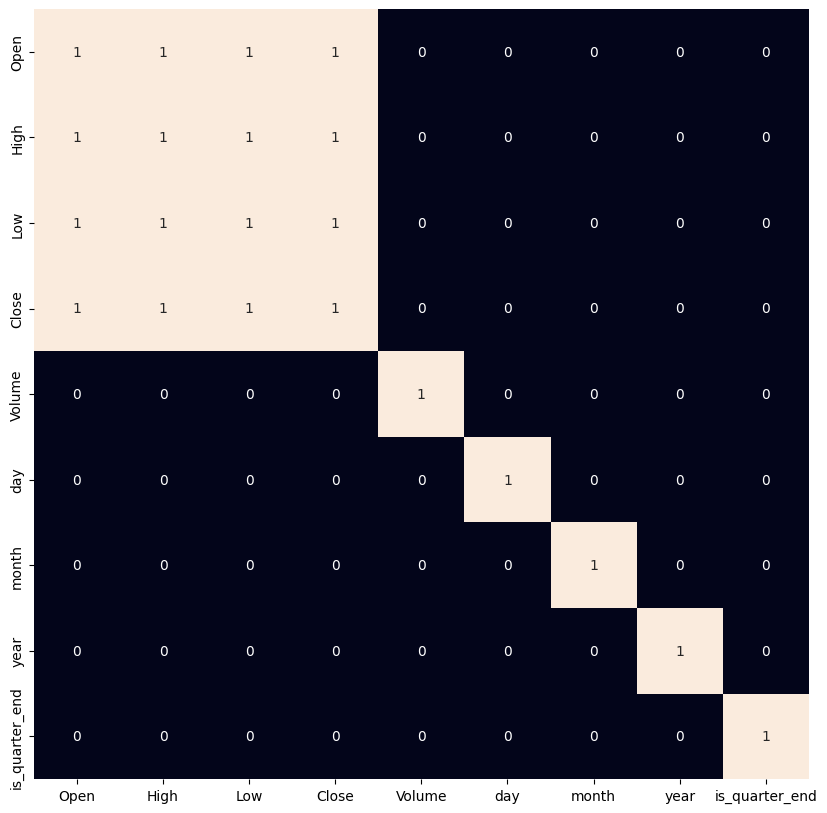

In [23]:
# adding features must ensure that there are no highly correlated features; they don't help the learning algo
# visualise a heatmap as per the correlation of features
plt.figure(figsize=(10, 10))

sb.heatmap(df[numeric_columns].corr() > 0.9, annot=True, cbar=False)
plt.show()

In [24]:
# the newly added features are not highly correlated, so they can be used to  build the model

In [25]:
# Data Splitting and Normalization
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2174, 3) (242, 3)


In [26]:
# Model Development and Evaluation
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5228802330060918
Validation Accuracy :  0.4923371647509579

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5294551196569256
Validation Accuracy :  0.4625068418171866

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

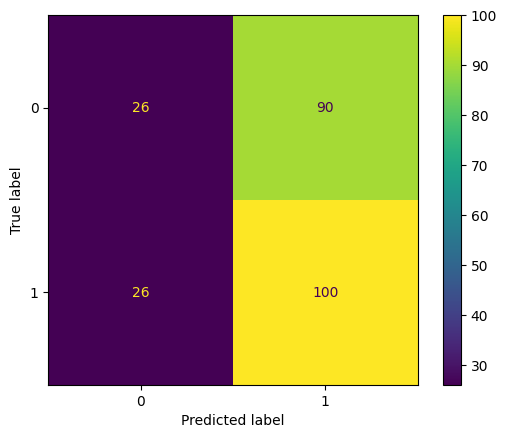

In [27]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = models[0].predict(X_valid)
conf_mat = confusion_matrix(Y_valid, y_pred)

display = ConfusionMatrixDisplay(conf_mat, display_labels=models[0].classes_)
display.plot()